## II. ANALYZING AIR QUALITY IN BANGKOK

In [320]:
import pandas as pd
import requests
import folium
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading the data

In [321]:
# Package the request, send the request and catch the response: r
r = requests.get('https://api.openaq.org/v1/measurements?limit=10000&city=Bangkok')
json_data = r.json()['results']

In [322]:
rows_list = []

for m in json_data:
    row = {'city': m['city'],
           'lon': m['coordinates']['longitude'],
           'lat': m['coordinates']['latitude'],
           'time': m['date']['local'],
           'loc': m['location'],
           'param': m['parameter'],
           'unit': m['unit'],
           'value': m['value']
          }
    rows_list.append(row)

data = pd.DataFrame(rows_list) 
data = data[['city','lon','lat','time','loc','param','unit','value']]

In [323]:
data.shape

(10000, 8)

In [324]:
data.head()

,city,lon,lat,time,loc,param,unit,value
0,Bangkok,100.605741,13.666116,2017-11-20T20:00:00+07:00,"Bangna, Bangna",no2,ppm,0.036
1,Bangkok,100.486604,13.727559,2017-11-20T20:00:00+07:00,"Intarapitak Rd., Thon Buri",so2,ppm,0.001
2,Bangkok,100.605741,13.666116,2017-11-20T20:00:00+07:00,"Bangna, Bangna",co,ppm,1.050
3,Bangkok,100.505812,13.668461,2017-11-20T20:00:00+07:00,"Samae Dam, Bang Khun Thian",co,ppm,0.780
4,Bangkok,100.536494,13.729830,2017-11-20T20:00:00+07:00,"Rama IV Rd., Pathum Wan",co,ppm,1.850


## 2. Getting acquainted with the data

### Counts per values

In [325]:
def count_by(df, col_name):
    print('-'*30)
    print('# of measurements by: "' + col_name + '"\n\n', data[col_name].value_counts())

In [326]:
for c in ['city', 'loc', 'param', 'unit']:
    count_by(data, c)

------------------------------
# of measurements by: "city"

 Bangkok    10000
Name: city, dtype: int64
------------------------------
# of measurements by: "loc"

 Intarapitak Rd., Thon Buri       2102
Bangna, Bangna                   1922
Samae Dam, Bang Khun Thian       1573
Khlong Chan, Bang kapi           1435
Lat Phrao Rd., Wang Thonglang    1402
Rama IV Rd., Pathum Wan          1177
Chong Nonsi, Yannawa              337
Pubpla, Wang Thonglang             45
Samsen Nai, Khet Phaya Thai         7
Name: loc, dtype: int64
------------------------------
# of measurements by: "param"

 no2     2706
pm10    2689
co      1992
o3      1716
so2      897
Name: param, dtype: int64
------------------------------
# of measurements by: "unit"

 ppm      7311
µg/m³    2689
Name: unit, dtype: int64


### Mapping measurement locations

In [327]:
# https://folium.readthedocs.io/en/latest/quickstart.html#getting-started
# https://deparkes.co.uk/2016/06/10/folium-map-tiles/
# http://nbviewer.jupyter.org/github/python-visualization/folium/tree/master/examples/

In [328]:
map_loc = folium.Map(location=[13.7563, 100.5018], tiles='cartodbpositron', zoom_start=11)

In [329]:
# Locations of interest
data[['loc', 'lon', 'lat']].drop_duplicates()

,loc,lon,lat
0,"Bangna, Bangna",100.605741,13.666116
1,"Intarapitak Rd., Thon Buri",100.486604,13.727559
3,"Samae Dam, Bang Khun Thian",100.505812,13.668461
4,"Rama IV Rd., Pathum Wan",100.536494,13.729830
9,"Khlong Chan, Bang kapi",100.636548,13.781520
11,"Chong Nonsi, Yannawa",100.547345,13.708041
14,"Lat Phrao Rd., Wang Thonglang",100.596078,13.792635
1923,"Pubpla, Wang Thonglang",100.614562,13.769630
6615,"Samsen Nai, Khet Phaya Thai",100.537798,13.780444


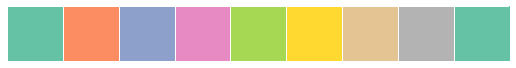

In [330]:
nb_loc = len(data[['loc', 'lon', 'lat']].drop_duplicates())
color_palette = sns.color_palette("Set2", nb_loc)
sns.palplot(color_palette)

In [331]:
col_idx = 0
for row in data[['loc', 'lon', 'lat']].drop_duplicates().itertuples():
    location, lon, lat = row[1:4]
    folium.CircleMarker([lat, lon],
                        radius=10,
                        popup='<i>' + location + '</i>',
                        color=color_palette.as_hex()[col_idx],
                        fill=True,
                        fill_color=color_palette.as_hex()[col_idx],
                        fill_opacity=0.8,
                        line_opacity=0.8
                       ).add_to(map_loc)
    col_idx += 1

In [332]:
map_loc

### The case of Particulate Matter 10 [pm10]

http://www.who.int/mediacentre/factsheets/fs313/en/ guidelines:
* Limit daily average per day 50 ug/m3
* Limit yearly average per day 40 ug/m3

In [333]:
pm10 = data[data.param == 'pm10']

In [334]:
pm10.head()

,city,lon,lat,time,loc,param,unit,value
8,Bangkok,100.536494,13.729830,2017-11-20T20:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,52.0
9,Bangkok,100.636548,13.781520,2017-11-20T20:00:00+07:00,"Khlong Chan, Bang kapi",pm10,µg/m³,28.0
11,Bangkok,100.547345,13.708041,2017-11-20T20:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,42.0
13,Bangkok,100.605741,13.666116,2017-11-20T20:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,34.0
17,Bangkok,100.505812,13.668461,2017-11-20T20:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,72.0


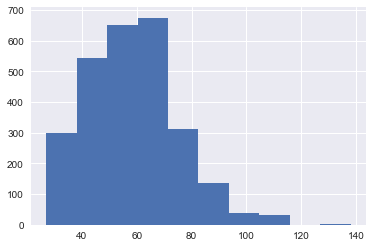

In [335]:
pm10['value'].hist()

In [336]:
locations = data[['loc', 'lon', 'lat']].drop_duplicates()['loc'].values

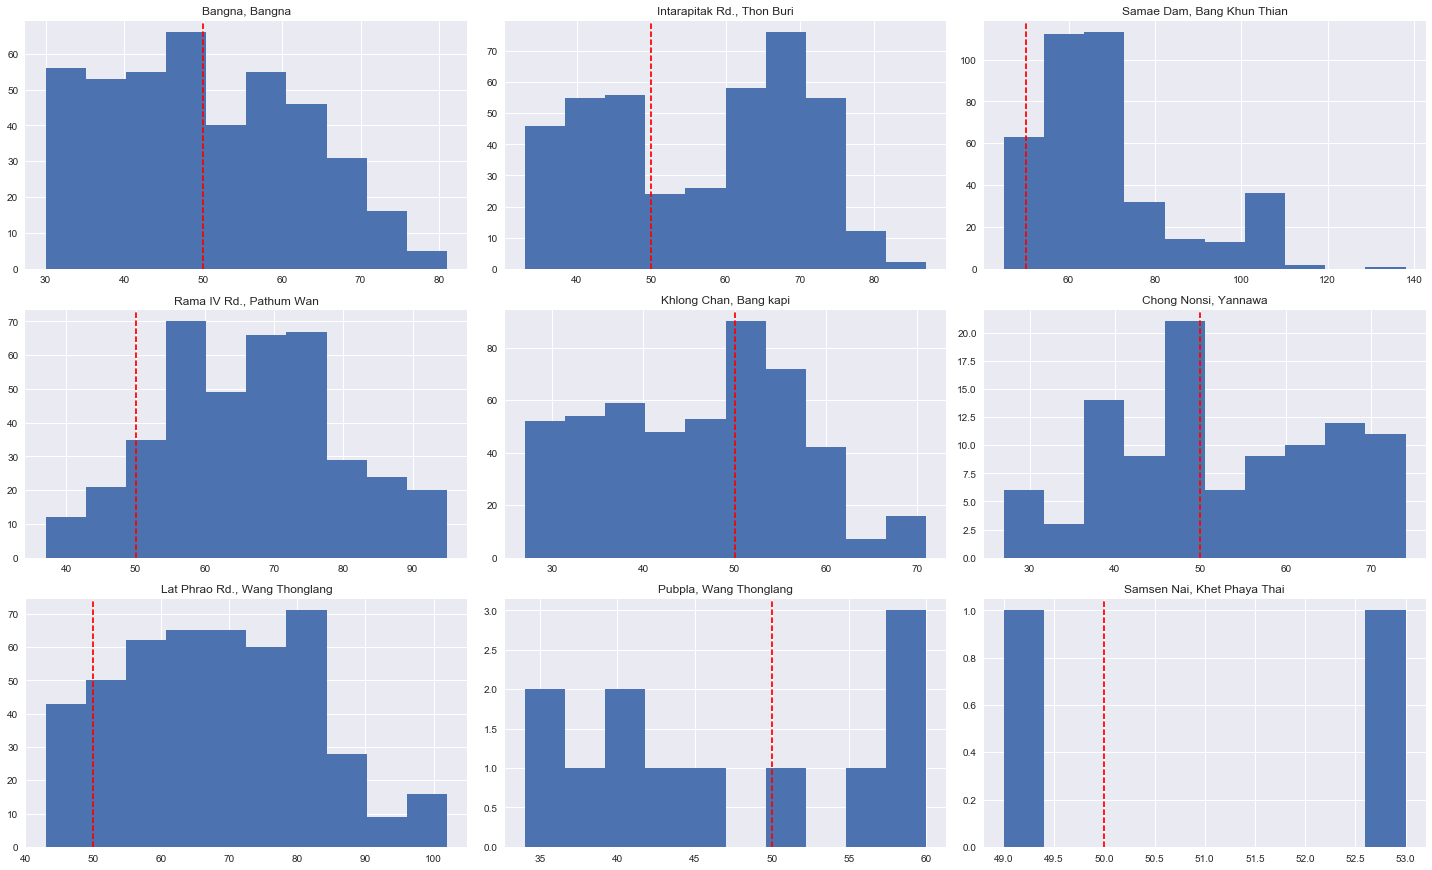

In [337]:
plt.rcParams['figure.figsize'] = (20, 20)
def draw_histograms_by_loc(n_rows, n_cols):
    locations = data[['loc', 'lon', 'lat']].drop_duplicates()['loc'].values
    fig = plt.figure()
    #plt.title("PM10 concentration")
    for i, loc in enumerate(locations):
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        pm10[pm10['loc'] == loc]['value'].hist(bins=10, ax=ax)
        plt.axvline(x=50, color='r', linestyle='--')
        ax.set_title(loc)
    fig.tight_layout()  # Improves appearance a bit.
    plt.show()

draw_histograms_by_loc(5, 3)

### Exploring time dimensions

In [340]:
pm10.head(20)

,city,lon,lat,time,loc,param,unit,value
8,Bangkok,100.536494,13.729830,2017-11-20T20:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,52.0
9,Bangkok,100.636548,13.781520,2017-11-20T20:00:00+07:00,"Khlong Chan, Bang kapi",pm10,µg/m³,28.0
11,Bangkok,100.547345,13.708041,2017-11-20T20:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,42.0
13,Bangkok,100.605741,13.666116,2017-11-20T20:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,34.0
17,Bangkok,100.505812,13.668461,2017-11-20T20:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,72.0
20,Bangkok,100.596078,13.792635,2017-11-20T20:00:00+07:00,"Lat Phrao Rd., Wang Thonglang",pm10,µg/m³,56.0
21,Bangkok,100.486604,13.727559,2017-11-20T20:00:00+07:00,"Intarapitak Rd., Thon Buri",pm10,µg/m³,40.0
24,Bangkok,100.505812,13.668461,2017-11-20T19:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,75.0
25,Bangkok,100.536494,13.729830,2017-11-20T19:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,54.0
28,Bangkok,100.605741,13.666116,2017-11-20T19:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,35.0


In [341]:
pm10_rot = pm10.set_index(pd.DatetimeIndex(pm10['time']), inplace=False)

In [342]:
pm10_rot.head()

,city,lon,lat,time,loc,param,unit,value
time,,,,,,,,
2017-11-20 13:00:00,Bangkok,100.536494,13.729830,2017-11-20T20:00:00+07:00,"Rama IV Rd., Pathum Wan",pm10,µg/m³,52.0
2017-11-20 13:00:00,Bangkok,100.636548,13.781520,2017-11-20T20:00:00+07:00,"Khlong Chan, Bang kapi",pm10,µg/m³,28.0
2017-11-20 13:00:00,Bangkok,100.547345,13.708041,2017-11-20T20:00:00+07:00,"Chong Nonsi, Yannawa",pm10,µg/m³,42.0
2017-11-20 13:00:00,Bangkok,100.605741,13.666116,2017-11-20T20:00:00+07:00,"Bangna, Bangna",pm10,µg/m³,34.0
2017-11-20 13:00:00,Bangkok,100.505812,13.668461,2017-11-20T20:00:00+07:00,"Samae Dam, Bang Khun Thian",pm10,µg/m³,72.0


In [343]:
# Now comes the magic of Pandas
pm10_rot = pm10_rot.pivot(columns='loc', values='value')

In [344]:
pm10_rot.head()

loc,"Bangna, Bangna","Chong Nonsi, Yannawa","Intarapitak Rd., Thon Buri","Khlong Chan, Bang kapi","Lat Phrao Rd., Wang Thonglang","Pubpla, Wang Thonglang","Rama IV Rd., Pathum Wan","Samae Dam, Bang Khun Thian","Samsen Nai, Khet Phaya Thai"
time,,,,,,,,,
2017-10-30 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,67.0,NaN,NaN
2017-10-30 02:00:00,64.0,NaN,68.0,57.0,78.0,NaN,67.0,NaN,NaN
2017-10-30 03:00:00,65.0,NaN,67.0,57.0,77.0,NaN,67.0,NaN,NaN
2017-10-30 04:00:00,65.0,NaN,67.0,58.0,78.0,NaN,67.0,NaN,NaN
2017-10-30 05:00:00,65.0,NaN,67.0,58.0,78.0,NaN,67.0,NaN,NaN


array([<matplotlib.axes._subplots.AxesSubplot object at 0x11ff5fcc0>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x11ce6b4e0>], dtype=object)

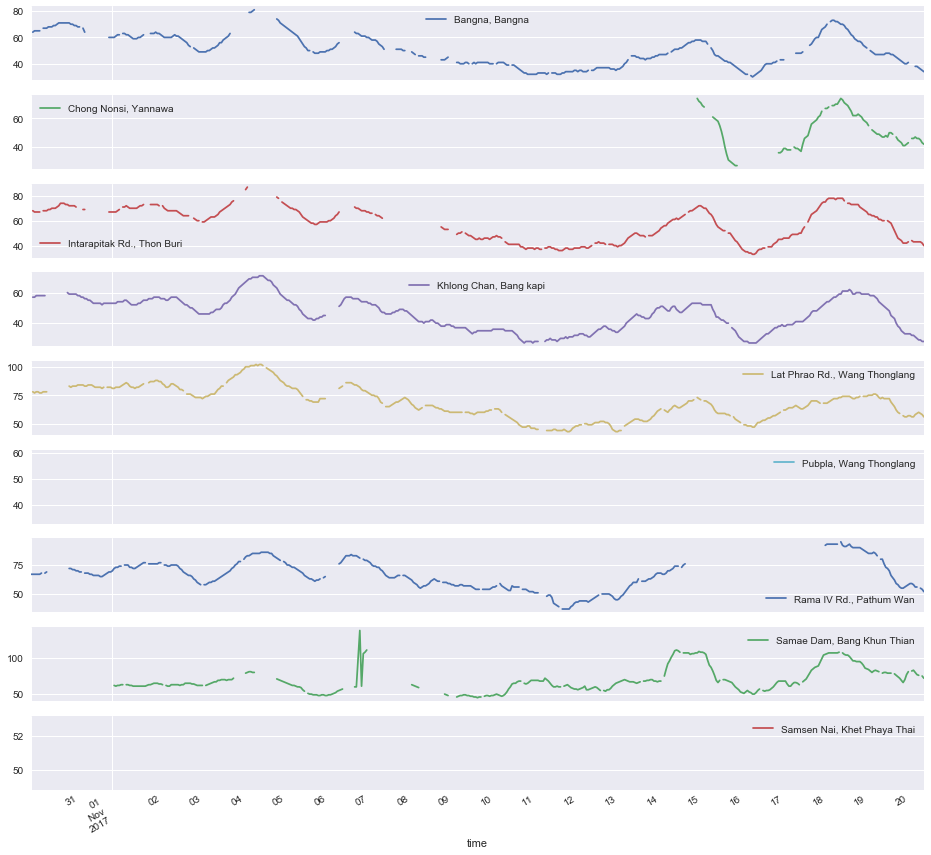

In [345]:
plt.rcParams['figure.figsize'] = (16, 16)
pm10_rot.plot(subplots=True)